In [24]:
%matplotlib notebook
import os
import os.path as path
import pandas as pd
import h5py
import numpy as np
from faker import Factory
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
from plotly.graph_objs import *
import plotly
from ipywidgets import fixed, interact_manual, widgets
import plotly.graph_objects as go
import plotly.express as plot_x

# Local module and scripts
from pyccapt.calibration.calibration_tools import data_tools, variables, tools, reconstruction
from pyccapt.calibration.calibration_tools import reconstruction
from pyccapt.calibration.calibration_tools import widgets as wd


In [25]:
save_fig=False
plot_fig=True 

In [26]:
# flightPathLength = 110 # mm 
# # The initial value for t_0
# t0 = 51.74 # ns

# dataset name
# AL_data_b
# OLO_AL_6_data
# OLO_W_6_data
# OLO_Ni_8_data
# X6Cr17_2V30Min_5_data
# data_1029_Jun-27-2022_15-53_Pd
# data_115_Jul-27-2022_17-44_Powersweep3

In [27]:
tdc, pulse_mode, dataset, flightPathLength_d, t0_d = wd.dataset_tdc_selection()
display(tdc, pulse_mode, dataset, flightPathLength_d, t0_d)

Dropdown(description='TDC model:', options=('surface_concept', 'roentdec'), value='surface_concept')

Dropdown(description='Pulse mode:', options=('voltage', 'laser'), value='voltage')

Text(value='OLO_AL_6_data', description='Dataset:', placeholder='Paste ticket description here!')

Text(value='110', description='Flight path length:', placeholder='Flight path length')

Text(value='51.74', description='t0:', placeholder='T_0 of the instrument')

$$\textbf{You can specify which dataset to use in below block}$$

In [28]:
tdc_model = tdc.value
pulse_mode_ini = pulse_mode.value

dataset_name = dataset.value

flightPathLength_ini = float(flightPathLength_d.value) # mm 
# The initial value for t_0
t0 = float(t0_d.value) # ns

p = path.abspath(path.join("", "../../../.."))

variables.init()

path_main = os.path.join(p, 'tests//data')
filename_main = path_main + '//' + dataset_name + '.h5'

variables.path = os.path.join(p, 'tests//results//ion_type_selection')
variables.result_path = os.path.join(p, 'tests/results/reconstruction/' + dataset_name)
if not os.path.isdir(variables.result_path):
        os.makedirs(variables.result_path, mode=0o777, exist_ok=True)
        
filename = variables.path + '//' + dataset_name + '//' + dataset_name + '.h5'


head, tail = os.path.split(filename)
figname = os.path.splitext(tail)[0]

data = data_tools.read_hdf5_through_pandas(filename)



In [29]:
data

,high_voltage (V),pulse (V),start_counter,t (ns),x (mm),y (mm),pulse_pi,ion_pp,mc (Da),element,color
0,5216.226562,5216.226562,1572.0,633.384306,-0.031837,0.859592,0.0,1.0,27.713360,0,0
1,5216.226562,5216.226562,1791.0,628.981470,-0.350204,-18.720000,219.0,1.0,27.003132,Al27(1+),#2c0359
2,5216.226562,5216.226562,1992.0,635.510286,-11.906939,2.610612,201.0,1.0,27.493455,0,0
3,5216.226562,5216.226562,2429.0,624.222018,7.195102,-0.827755,437.0,1.0,26.965459,Al27(1+),#2c0359
4,5216.226562,5216.226562,3220.0,629.276364,14.644898,7.449796,791.0,1.0,27.027015,Al27(1+),#2c0359
...,...,...,...,...,...,...,...,...,...,...,...
1858635,5711.025879,5711.025879,3626.0,601.419168,-4.998367,-1.846531,152.0,1.0,26.985305,Al27(1+),#2c0359
1858636,5711.025879,5711.025879,3641.0,602.674182,-0.827755,-14.867755,15.0,1.0,26.971058,Al27(1+),#2c0359
1858637,5711.025879,5711.025879,4538.0,600.644214,-6.271837,3.565714,897.0,1.0,26.801420,Al27(1+),#2c0359
1858638,5711.025879,5711.025879,5881.0,459.993492,34.097143,5.380408,1343.0,1.0,13.680422,0,0


In [30]:
# exctract needed data from Pandas data frame as an numpy array
dld_highVoltage = data['high_voltage (V)'].to_numpy()
dld_x = data['x (mm)'].to_numpy()
dld_y = data['y (mm)'].to_numpy()
mc = data['mc (Da)'].to_numpy()

11-08-2022 12:08:43 | INFO | Selected Mode = count
11-08-2022 12:08:43 | INFO | Selected Mode = count


<IPython.core.display.Javascript object>


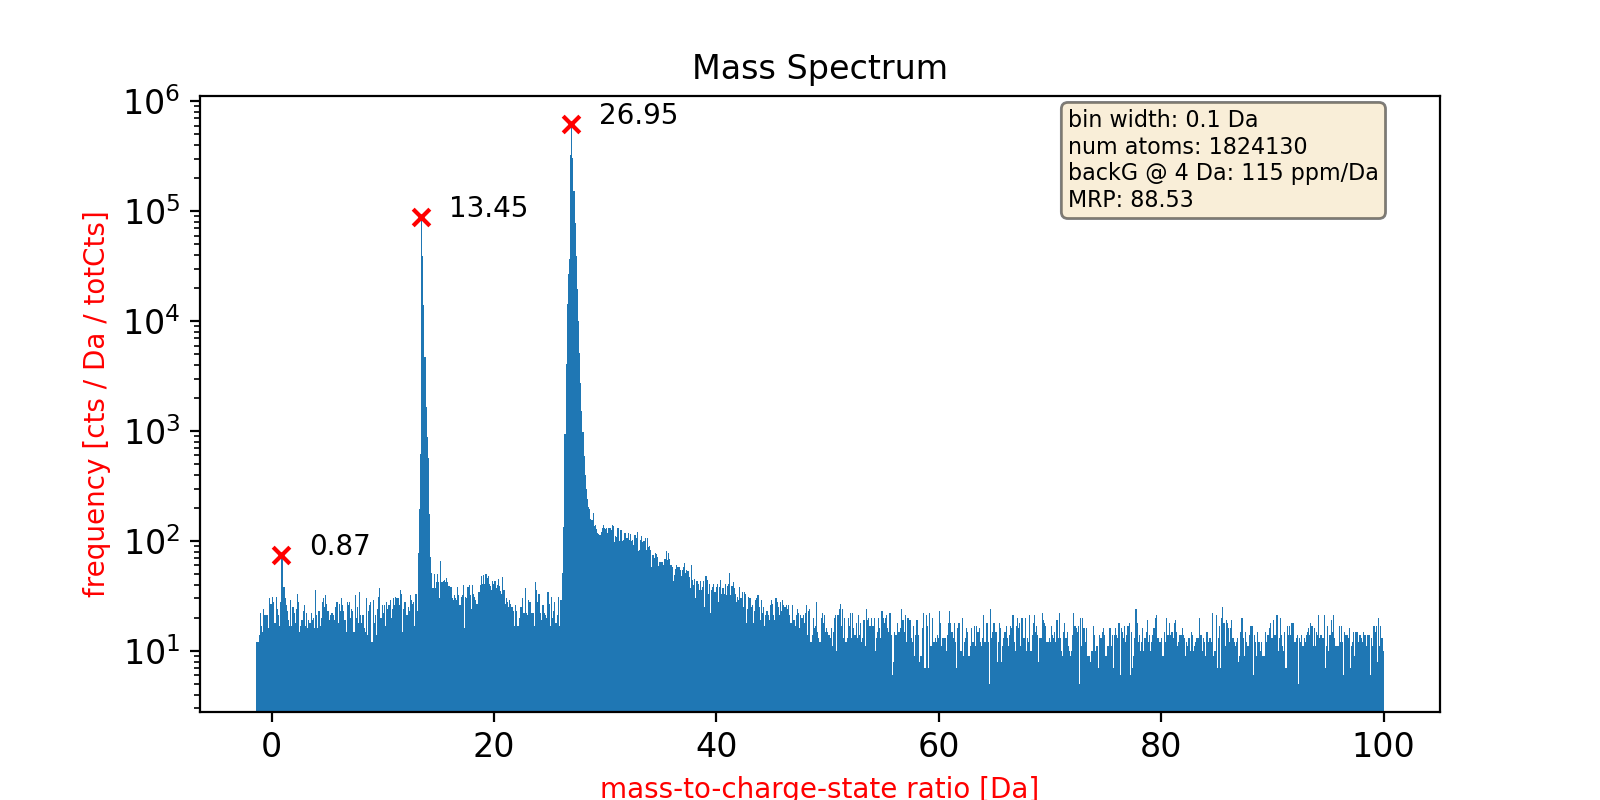

Mass resolving power for the highest peak (MRP --> m/m_2-m_1): [88.52749516]
Peaks  0 is: 0.87 peak window sides are: 0.77 - 1.18
Peaks  1 is: 13.45 peak window sides are: 13.35 - 13.55
Peaks  2 is: 26.95 peak window sides are: 26.74 - 27.05


In [31]:
max_hist_p, left_right_peaks_p, peaks_sides_p, max_paek_edges_p, index_max_p = tools.massSpecPlot(mc[mc < 100], 0.1, prominence=40, distance=2, text_loc='right', percent=50, plot=True, fig_name='mc'+figname, peaks_find_plot=True)
mrp = (max_hist_p / (left_right_peaks_p[1] - left_right_peaks_p[0]))
print('Mass resolving power for the highest peak (MRP --> m/m_2-m_1):', mrp)
peak_list = []
for i in range(len(peaks_sides_p)):
    peak_list.append(peaks_sides_p[i,0])
    print('Peaks ', i, 'is: {:.2f}'.format(peaks_sides_p[i,0]), 'peak window sides are: {:.2f} - {:.2f}'.format(peaks_sides_p[i,2], peaks_sides_p[i,3]))

In [33]:
element_selected = wd.density_field_selection()
display(element_selected)

Dropdown(description='Element', options=((1, 'H', 52.7, 0.0), (2, 'He', 28.7, 0.0), (3, 'Li', 46.3, 14.0), (4,…

In [34]:
avg_dens = element_selected.value[2]
field_evap = element_selected.value[3]
flight_path_length = flightPathLength_ini

In [35]:
def rotary_fig(fig1):
    fig = go.Figure(fig1)
    x_eye = -1.25
    y_eye = 2
    z_eye = 0.5

    fig.update_scenes(xaxis_visible=False, yaxis_visible=False,zaxis_visible=False )

    fig.update_layout(
             width=600,
             height=600,
             scene_camera_eye=dict(x=x_eye, y=y_eye, z=z_eye),
             updatemenus=[dict(type='buttons',
                      showactive=False,
                      y=1.2,
                      x=0.8,
                      xanchor='left',
                      yanchor='bottom',
                      pad=dict(t=45, r=10),
                      buttons=[dict(label='Play',
                                     method='animate',
                                     args=[None, dict(frame=dict(duration=15, redraw=True), 
                                                                 transition=dict(duration=0),
                                                                 fromcurrent=True,
                                                                 mode='immediate'
                                                                )]
                                                )
                                          ]
                                  )
                            ]
    )


    def rotate_z(x, y, z, theta):
        w = x+1j*y
        return np.real(np.exp(1j*theta)*w), np.imag(np.exp(1j*theta)*w), z

    frames=[]
    for t in np.arange(0, 20, 0.1):
        xe, ye, ze = rotate_z(x_eye, y_eye, z_eye, -t)
        frames.append(go.Frame(layout=dict(scene_camera_eye=dict(x=xe, y=ye, z=ze))))
    fig.frames=frames
    plotly.offline.plot(fig, filename=variables.result_path + '\\{fn}.html'.format(fn='rota_'+figname), show_link=True, auto_open=False)
#     fig.show()

In [36]:
def reconstruction_calculation_plot(dld_x, dld_y, dld_highVoltage, flight_path_length, kf, det_eff, icf, field_evap, avg_dens, element_percentage, rotary_fig_save):
    
    px, py, pz = reconstruction.atom_probe_recons_from_detector_Gault_et_al(dld_x, dld_y, dld_highVoltage, flight_path_length, kf, det_eff, icf, field_evap, avg_dens)
#     px, py, pz = reconstruction.atom_probe_recons_Bas_et_al(dld_x, dld_y, dld_highVoltage, flight_path_length, kf, det_eff, icfe, field_evap, avg_dens)
    
    data['rx (nm)'] = px
    data['ry (nm)'] = py
    data['rz (nm)'] = pz
    
    element = data.element.unique()
    color = data.color.unique()
    # remove zero from list
    phases = [i for i in element if i != 0]
    colors = [i for i in color if i != 0]
    
    element_percentage = element_percentage.replace('[', '')
    element_percentage = element_percentage.replace(']', '')
    element_percentage = element_percentage.split(',')
    
    fig = go.Figure()
    for index, elemen in enumerate(phases):
        df_s = data[data['color'].str.contains(colors[index], na=False)]
        remove_n = int(len(df_s) - (len(df_s) * float(element_percentage[index])))
#         print(len(df_s))
        drop_indices = np.random.choice(df_s.index, remove_n, replace=False)
        df_subset = df_s.drop(drop_indices)
#         print(len(df_subset))
        fig.add_trace(go.Scatter3d(x=df_subset['rx (nm)'], y=df_subset['ry (nm)'], z=df_subset['rz (nm)'], mode='markers',
                                   name=elemen,
                                   showlegend=True,
                                  marker = dict(
                                    size=2,
                                    color=colors[index],
                                    opacity=.2,
                                        )
                                  ))
#         print(elemen)
    fig.update_scenes(
        xaxis_title="x (nm)",
        yaxis_title="y (nm)",
        zaxis_title="z (nm)")
    fig.update_layout( legend_title="Elements:", title="APT",)
    fig.update_scenes(zaxis_autorange="reversed")
    fig.update_layout(legend= {'itemsizing': 'constant'})
    
    if rotary_fig_save == 'True':
        rotary_fig(fig)
        
    plotly.offline.plot(fig, filename=variables.result_path + '\\{fn}.html'.format(fn=figname), show_link=True, auto_open=False)
    fig.show()

In [37]:
# colors = ['#ab2020', '#224d90', '#47684c', '#e2e14c', '#0492c2', '#7ea1ad', '#8b324d', '#7b7cf8', '#74632b', '#eed5b7', '#50ffd6', '#c9f2c9','#99c35f', '#0c2aac']

In [38]:
element = data.element.unique()
color = data.color.unique()
# remove zero from list
phases = [i for i in element if i != 0]
colors = [i for i in color if i != 0]
element_percentage = [0.01] * len(phases)
element_percentage = str(element_percentage)
print('Elemetns:', phases)
print('Element colors:', colors)
print('Percentage of each element to plot:', element_percentage)

Elemetns: ['Al27(1+)', 'Al27(2+)', 'H1(1+)']
Element colors: ['#2c0359', '#be9cad', '#4f124d']
Percentage of each element to plot: [0.01, 0.01, 0.01]


In [40]:
interact_manual(reconstruction_calculation_plot, dld_x=fixed(dld_x), dld_y=fixed(dld_y), dld_highVoltage=fixed(dld_highVoltage), flight_path_length=fixed(flight_path_length),
                kf=widgets.FloatText(value=4), det_eff=widgets.FloatText(value=0.7), icf=widgets.FloatText(value=1.4),
                field_evap=widgets.FloatText(value=field_evap),
               avg_dens=widgets.FloatText(value=avg_dens), element_percentage=widgets.Textarea(value=element_percentage),
               rotary_fig_save=widgets.Dropdown(options=['True', 'False'], value='False'));

interactive(children=(FloatText(value=4.0, description='kf'), FloatText(value=0.7, description='det_eff'), Flo…

In [18]:
data

,high_voltage (V),pulse (V),start_counter,t (ns),x (mm),y (mm),pulse_pi,ion_pp,mc (Da),element,color,rx (nm),ry (nm),rz (nm)
0,5216.226562,5216.226562,1572.0,633.384306,-0.031837,0.859592,0.0,1.0,27.713360,0,0,-0.027809,0.750848,0.004120
1,5216.226562,5216.226562,1791.0,628.981470,-0.350204,-18.720000,219.0,1.0,27.003132,Al27(1+),#2c0359,-0.299869,-16.029368,1.898736
2,5216.226562,5216.226562,1992.0,635.510286,-11.906939,2.610612,201.0,1.0,27.493455,0,0,-10.312656,2.261064,0.816889
3,5216.226562,5216.226562,2429.0,624.222018,7.195102,-0.827755,437.0,1.0,26.965459,Al27(1+),#2c0359,6.266145,-0.720884,0.290471
4,5216.226562,5216.226562,3220.0,629.276364,14.644898,7.449796,791.0,1.0,27.027015,Al27(1+),#2c0359,12.596940,6.408009,1.470937
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1858635,5711.025879,5711.025879,3626.0,601.419168,-4.998367,-1.846531,152.0,1.0,26.985305,Al27(1+),#2c0359,-4.772563,-1.763112,NaN
1858636,5711.025879,5711.025879,3641.0,602.674182,-0.827755,-14.867755,15.0,1.0,26.971058,Al27(1+),#2c0359,-0.781670,-14.039988,NaN
1858637,5711.025879,5711.025879,4538.0,600.644214,-6.271837,3.565714,897.0,1.0,26.801420,Al27(1+),#2c0359,-5.980342,3.399992,NaN
1858638,5711.025879,5711.025879,5881.0,459.993492,34.097143,5.380408,1343.0,1.0,13.680422,0,0,30.546395,4.820113,NaN


In [19]:
def projection(dld_x, dld_y, dld_highVoltage, flight_path_length, kf, det_eff, icf, field_evap, avg_dens, element_percentage, figname):
    ax = plt.figure().add_subplot(111)
    px, py, pz = reconstruction.atom_probe_recons_from_detector_Gault_et_al(dld_x, dld_y, dld_highVoltage, flight_path_length, kf, det_eff, icf, field_evap, avg_dens)
#     px, py, pz = reconstruction.atom_probe_recons_Bas_et_al(dld_x, dld_y, dld_highVoltage, flight_path_length, kf, det_eff, icfe, field_evap, avg_dens)
    
    data['rx (nm)'] = px
    data['ry (nm)'] = py
    data['rz (nm)'] = pz
    
    element = data.element.unique()
    color = data.color.unique()
    # remove zero from list
    phases = [i for i in element if i != 0]
    colors = [i for i in color if i != 0]
    
    element_percentage = element_percentage.replace('[', '')
    element_percentage = element_percentage.replace(']', '')
    element_percentage = element_percentage.split(',')
    
    for index, elemen in enumerate(phases):
        df_s = data[data['color'].str.contains(colors[index], na=False)]
        remove_n = int(len(df_s) - (len(df_s) * float(element_percentage[index])))
#         print(len(df_s))
        drop_indices = np.random.choice(df_s.index, remove_n, replace=False)
        df_subset = df_s.drop(drop_indices)
#         print(len(df_subset))

        ax.scatter(df_subset['ry (nm)'], df_subset['rz (nm)'], s=2, label=elemen)


    ax.xaxis.tick_top()
    ax.invert_yaxis()
    ax.set_xlabel('Y (nm)')
    ax.xaxis.set_label_position('top')
    ax.set_ylabel('Z (nm)')
    plt.legend()
    plt.savefig(variables.result_path + '\\output_{fn}.png'.format(fn=figname))

In [20]:
interact_manual(projection, dld_x=fixed(dld_x), dld_y=fixed(dld_y), dld_highVoltage=fixed(dld_highVoltage), flight_path_length=fixed(flight_path_length),
                kf=widgets.FloatText(value=4), det_eff=widgets.FloatText(value=0.7), icf=widgets.FloatText(value=1.4),
                field_evap=widgets.FloatText(value=field_evap),
               avg_dens=widgets.FloatText(value=avg_dens), element_percentage=widgets.Textarea(value=element_percentage)
               , figname=fixed(figname));

interactive(children=(FloatText(value=4.0, description='kf'), FloatText(value=0.7, description='det_eff'), Flo…

In [21]:
# save the new data
name_save_file = variables.result_path + '//' + dataset_name + '.h5'
data_tools.store_df_to_hdf(name_save_file, data, 'df')

d:\pyccapt\pyccapt\calibration\calibration_tools\data_tools.py:91: PerformanceWarning:


your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block1_values] [items->Index(['element', 'color'], dtype='object')]




In [22]:
name_save_file = variables.result_path + '//' + dataset_name + '.csv'
data.to_csv(name_save_file, index = False)


In [23]:
with h5py.File(variables.result_path + '//' + dataset_name + '_hdf.h5', "w") as f:
    for i in range(len(data.columns)):
        print(i)
        type_s = data.dtypes[i]
        data_s = data[data.columns[i]].to_numpy()
        if type_s == 'object':
            break
#             type_s = 'str'
#             data_s = data_s
        f.create_dataset(data.columns[i], data=data_s, dtype=type_s)


0
1
2
3
4
5
6
7
8
9


In [ ]:
def save_to_pos(self, filepath: str):
        """
        Write the roi to a standard pos file

        :param filepath: path of the pos file
        """
        validate.dir_is_writable(filepath)

        log.info("Writing pos file to: {}".format(filepath))

        dtype = n.dtype(">f4")
        out = n.hstack([self.xyz, self.mass[None].T]).astype(dtype)
        out.tofile(filepath, sep="")

def save_to_epos(self, filepath: str):
    """
    Write the roi to a standard extended pos file

    :param filepath: path of the epos file
    """
    validate.dir_is_writable(filepath)

    epos_misc_entries = ["tof", "dc_voltage", "pulse_voltage", "det_x", "det_y", "psl", "ipp"]
    if not all(i in self.misc.keys() for i in epos_misc_entries):
        raise AttributeError("Roi does not contain the required misc keys to write to epos")

    log.info("Writing epos file to: {}".format(filepath))
    out = n.zeros(int(self.counts), dtype=Roi._epos_dtype)
    out["xyz"] = self.xyz
    out["mass"] = self.mass
    out["tof"] = self.misc["tof"]
    out["dc_voltage"] = self.misc["dc_voltage"]
    out["pulse_voltage"] = self.misc["pulse_voltage"]
    out["det_x"] = self.misc["det_x"]
    out["det_y"] = self.misc["det_y"]
    out["psl"] = self.misc["psl"]
    out["ipp"] = self.misc["ipp"]
    out.tofile(filepath, sep="")

def save_to_rrng(self, filepath: str):
    """
    Write the roi to a standard extended pos file

    :param filepath: path of the epos file
    """
    validate.dir_is_writable(filepath)

    epos_misc_entries = ["tof", "dc_voltage", "pulse_voltage", "det_x", "det_y", "psl", "ipp"]
    if not all(i in self.misc.keys() for i in epos_misc_entries):
        raise AttributeError("Roi does not contain the required misc keys to write to epos")

    log.info("Writing epos file to: {}".format(filepath))
    out = n.zeros(int(self.counts), dtype=Roi._epos_dtype)
    out["xyz"] = self.xyz
    out["mass"] = self.mass
    out["tof"] = self.misc["tof"]
    out["dc_voltage"] = self.misc["dc_voltage"]
    out["pulse_voltage"] = self.misc["pulse_voltage"]
    out["det_x"] = self.misc["det_x"]
    out["det_y"] = self.misc["det_y"]
    out["psl"] = self.misc["psl"]
    out["ipp"] = self.misc["ipp"]
    out.tofile(filepath, sep="")